### Load packages

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv
import pickle


### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense


import tensorflow.keras.backend as K

### Import ZLP data

In [5]:
for file_name in os.listdir('Data/'):
    if fnmatch.fnmatch(file_name, '*.dat'):
        print(file_name)

ZLP_200 keV_2ms_008.dat
ZLP_200 keV_2ms_009.dat
01.dat
ZLP_200 keV_2ms_007.dat
ZLP_200 keV_2ms_006.dat
ZLP_200 keV_2ms_010.dat
ZLP_200 keV_2ms_004.dat
ZLP_200 keV_2ms_005.dat
ZLP_200 keV_2ms_002.dat
ZLP_200 keV_2ms_003.dat


In [6]:
%run EELS-ZLP.py


 ************************ Data files have been prepared ***************************** 


 ****************** Training and validation sets have been prepared **************** 

 prepare_single_data 
 prepare_semisingle_data 
 prepare_mixed_data


In [7]:
x_train, y_train, x_val, y_val = prepare_mix_data()


## Neural Network

### Create architecture

In [8]:
def make_model():
    model = tf.keras.Sequential()
    model.add(Dense(5, activation='relu', input_shape=(1,)))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1))
    return model

def std(y_true, y_pred):
    return tf.math.reduce_std(y_pred, axis=0)
   
def custom_cost(y_true, y_pred):
    '''Chi square function'''
    sigma = std(y_true, y_pred)
    return 1/N_train * tf.reduce_mean(tf.square((y_true-y_pred)/sigma))

def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

### Show sample of training data

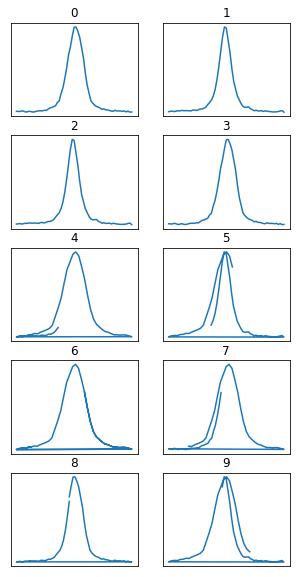

In [9]:
plt.figure(figsize=(5,10))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.plot(x_train[i*63 : (i+1)*63], y_train[i*63 :(i+1)*63])
    plt.title(i)
plt.show()

## Build architecture & start training

In [11]:
mode = 'Mixture'
epochsize = 30
batch_size = 3000


K.clear_session()
model = make_model()

if mode == 'Single':

    print ("********** Prepare training on single ZLP spectrum... ********** ")
    #x_train, y_train, x_val, y_val = prepare_single_data() ### Validation on the same spectrum
    x_train, y_train, x_val, y_val = prepare_semisingle_data() ### Validation on a different spectrum
    
    sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    
    model.compile(loss='mse',
              optimizer=sgd,
              metrics=[custom_cost])
    
    
    loss = model.fit(x_train, y_train, batch_size = batch_size, epochs=epochsize, verbose=0, validation_data = [x_val, y_val])
    print('********** Training finished ***********')
    
elif mode == 'Mixture':
    print ("********** Prepare training on mixed ZLP spectra... **********")
    x_train, y_train, x_val, y_val = prepare_mix_data()
    sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    
    model.compile(loss=custom_cost,
              optimizer=sgd,
              metrics=[custom_cost, std])
    model.summary()
    
    loss = model.fit(x_train, y_train, batch_size = batch_size, epochs=epochsize, verbose=0, validation_data = [x_val, y_val])
    print("********** Training completed! **********")
else:
    print("No mode specified. Training not possible.")
    


Instructions for updating:
Colocations handled automatically by placer.
********** Prepare training on mixed ZLP spectra... **********
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 10        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 46
Trainable params: 46
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
********** Training completed! **********


### Store data

In [12]:
hist_df = pd.DataFrame(loss.history) 
#save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
    
loss_data = pd.read_csv('history.csv')['loss']
chi_data = pd.read_csv('history.csv')['custom_cost']
val_loss_data = pd.read_csv('history.csv')['val_loss']
val_chi_data = pd.read_csv('history.csv')['val_custom_cost']

### Plot outputs

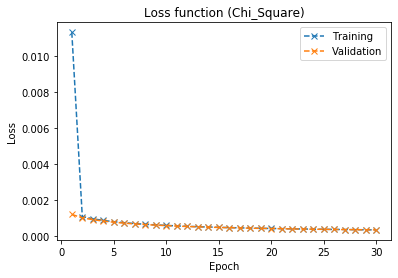

(0, 10)

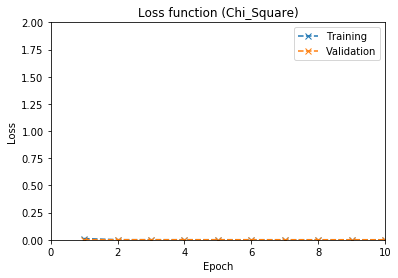

In [14]:
plt.figure()
plt.plot(np.linspace(1,epochsize,epochsize), loss_data,'x--', label='Training')
plt.plot(np.linspace(1,epochsize,epochsize), val_loss_data,'x--', label='Validation')
#plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss function (Chi_Square)')
#plt.ylim([0,10])
plt.savefig('Chi-Square')
plt.show()

plt.figure()
plt.plot(np.linspace(1,epochsize,epochsize), loss_data,'x--', label='Training')
plt.plot(np.linspace(1,epochsize,epochsize), val_loss_data,'x--', label='Validation')
#plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss function (Chi_Square)')
plt.ylim([0,2])
plt.xlim([0,10])
#plt.show()
